#Loading Model Dependencies

In [ ]:
!pip install yfinance==0.2.40 joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.50
    Uninstalling yfinance-0.2.50:
      Successfully uninstalled yfinance-0.2.50


In [ ]:
!apt-get install graphviz
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Bidirectional, TimeDistributed, MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model


# Reading Data from Yahoo Finanace

In [ ]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

In [ ]:
sns.set_style('whitegrid')


**Loading Data**

In [ ]:
yf.pdr_override()
tickers = ['^GSPC',  # S&P 500
           'AAPL',   # Apple
           'CRWD',   # CrowdStrike
           'RTX',    # Raytheon Technologies
           'GC=F',   ]  # Gold Futures


stock_data = {}
for stock in tickers:
  stock_data[stock] = yf.download(stock, start='2020-1-1', end='2024-12-1')


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
GSPC = stock_data['^GSPC']
AAPL = stock_data['AAPL']
CRWD = stock_data['CRWD']
RTX = stock_data['RTX']
GCF = stock_data['GC=F']

raw_data = [GSPC, AAPL, CRWD, RTX, GCF]
stock_names = ['S&P 500', 'Apple', 'CrowdStrike', 'Raytheon Technologies', 'Gold Futures']


for data, stock_name in zip(raw_data, stock_names):
    data["stock_name"] = stock_name

df = pd.concat(raw_data, axis=0)

df

,Open,High,Low,Close,Adj Close,Volume,stock_name
Date,,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000,S&P 500
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000,S&P 500
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000,S&P 500
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000,S&P 500
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000,S&P 500
...,...,...,...,...,...,...,...
2024-11-25,2689.399902,2689.399902,2616.800049,2616.800049,2616.800049,94,Gold Futures
2024-11-26,2625.600098,2625.600098,2620.300049,2620.300049,2620.300049,177858,Gold Futures
2024-11-27,2633.500000,2657.899902,2627.199951,2639.899902,2639.899902,61653,Gold Futures


## Data Exploration

In [ ]:
GSPC.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1237.000000,1237.000000,1237.000000,1237.000000,1237.000000,1.237000e+03
mean,4229.049202,4254.144730,4202.449568,4229.875862,4229.875862,4.384028e+09
std,738.562143,736.498646,740.970093,738.848604,738.848604,1.041793e+09
min,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,1.639500e+09
25%,3810.939941,3838.239990,3783.600098,3808.100098,3808.100098,3.752900e+09
50%,4195.080078,4213.419922,4175.040039,4193.799805,4193.799805,4.115670e+09
75%,4572.450195,4595.310059,4551.660156,4574.790039,4574.790039,4.719580e+09
max,6014.109863,6044.169922,6003.979980,6032.379883,6032.379883,9.976520e+09


In [ ]:
GSPC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1237 entries, 2020-01-02 to 2024-11-29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1237 non-null   float64
 1   High        1237 non-null   float64
 2   Low         1237 non-null   float64
 3   Close       1237 non-null   float64
 4   Adj Close   1237 non-null   float64
 5   Volume      1237 non-null   int64  
 6   stock_name  1237 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 77.3+ KB


# Data Visualization

Understanding the closing price for each stock

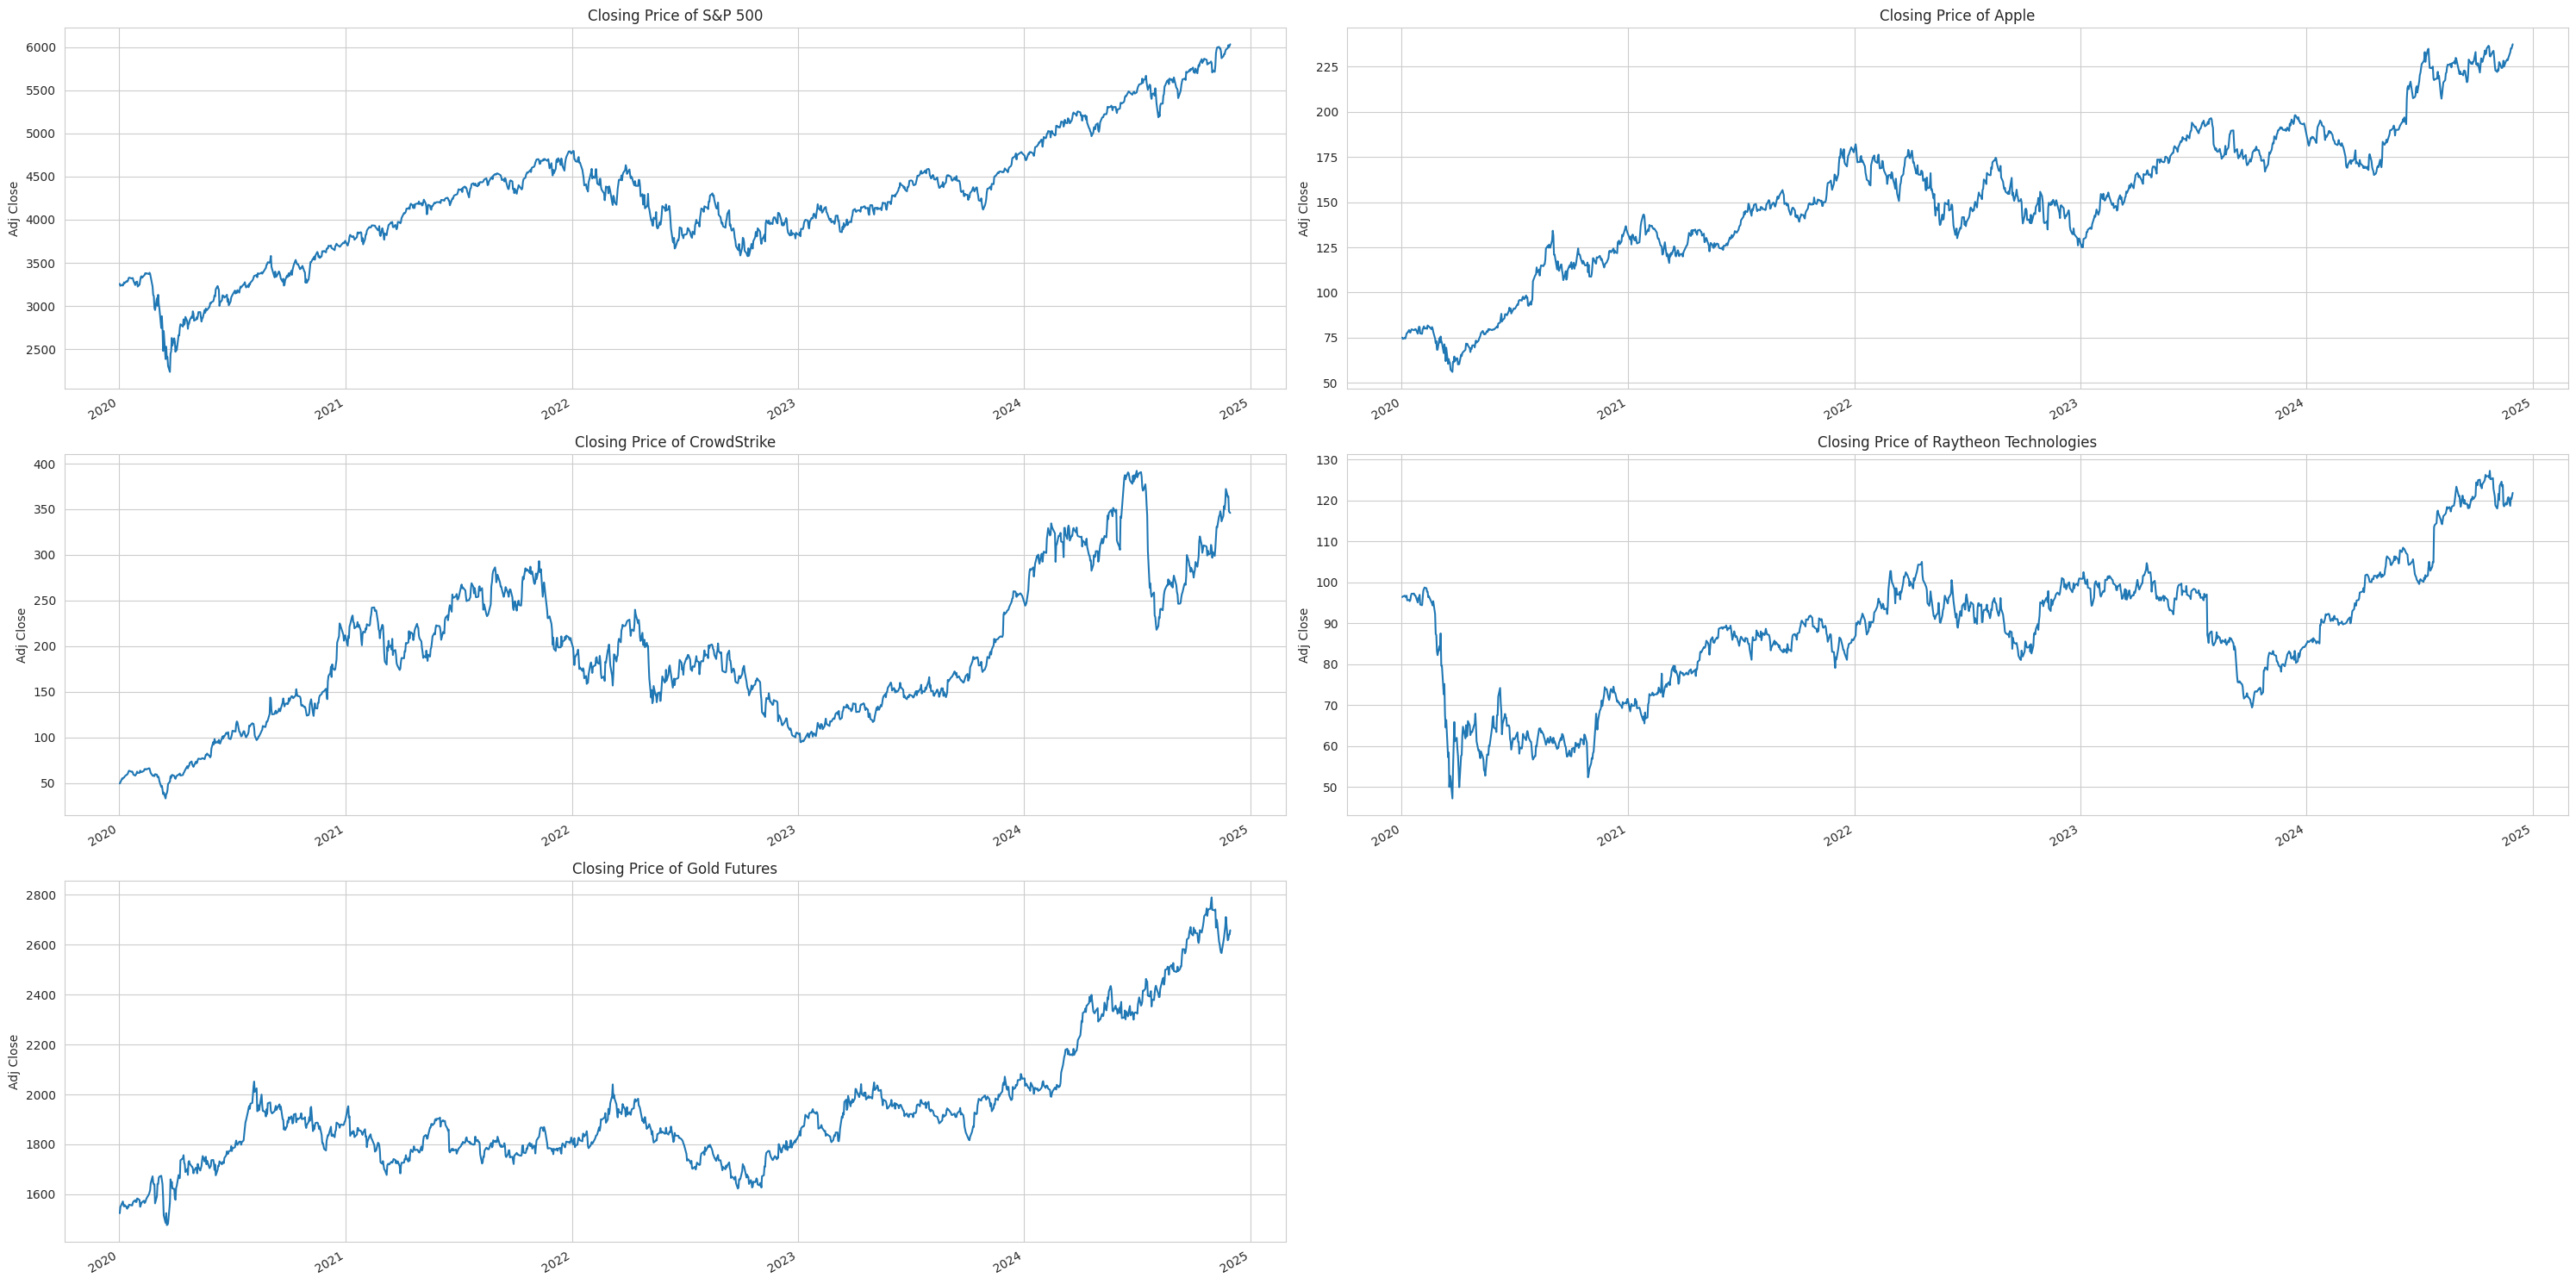

In [ ]:
plt.figure(figsize=(30, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)


for x in range(1, len(raw_data) + 1):
    plt.subplot(3, 2, x)
    raw_data[x - 1]['Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stock_names[x - 1]}")

plt.tight_layout()

Understanding Volume Sales

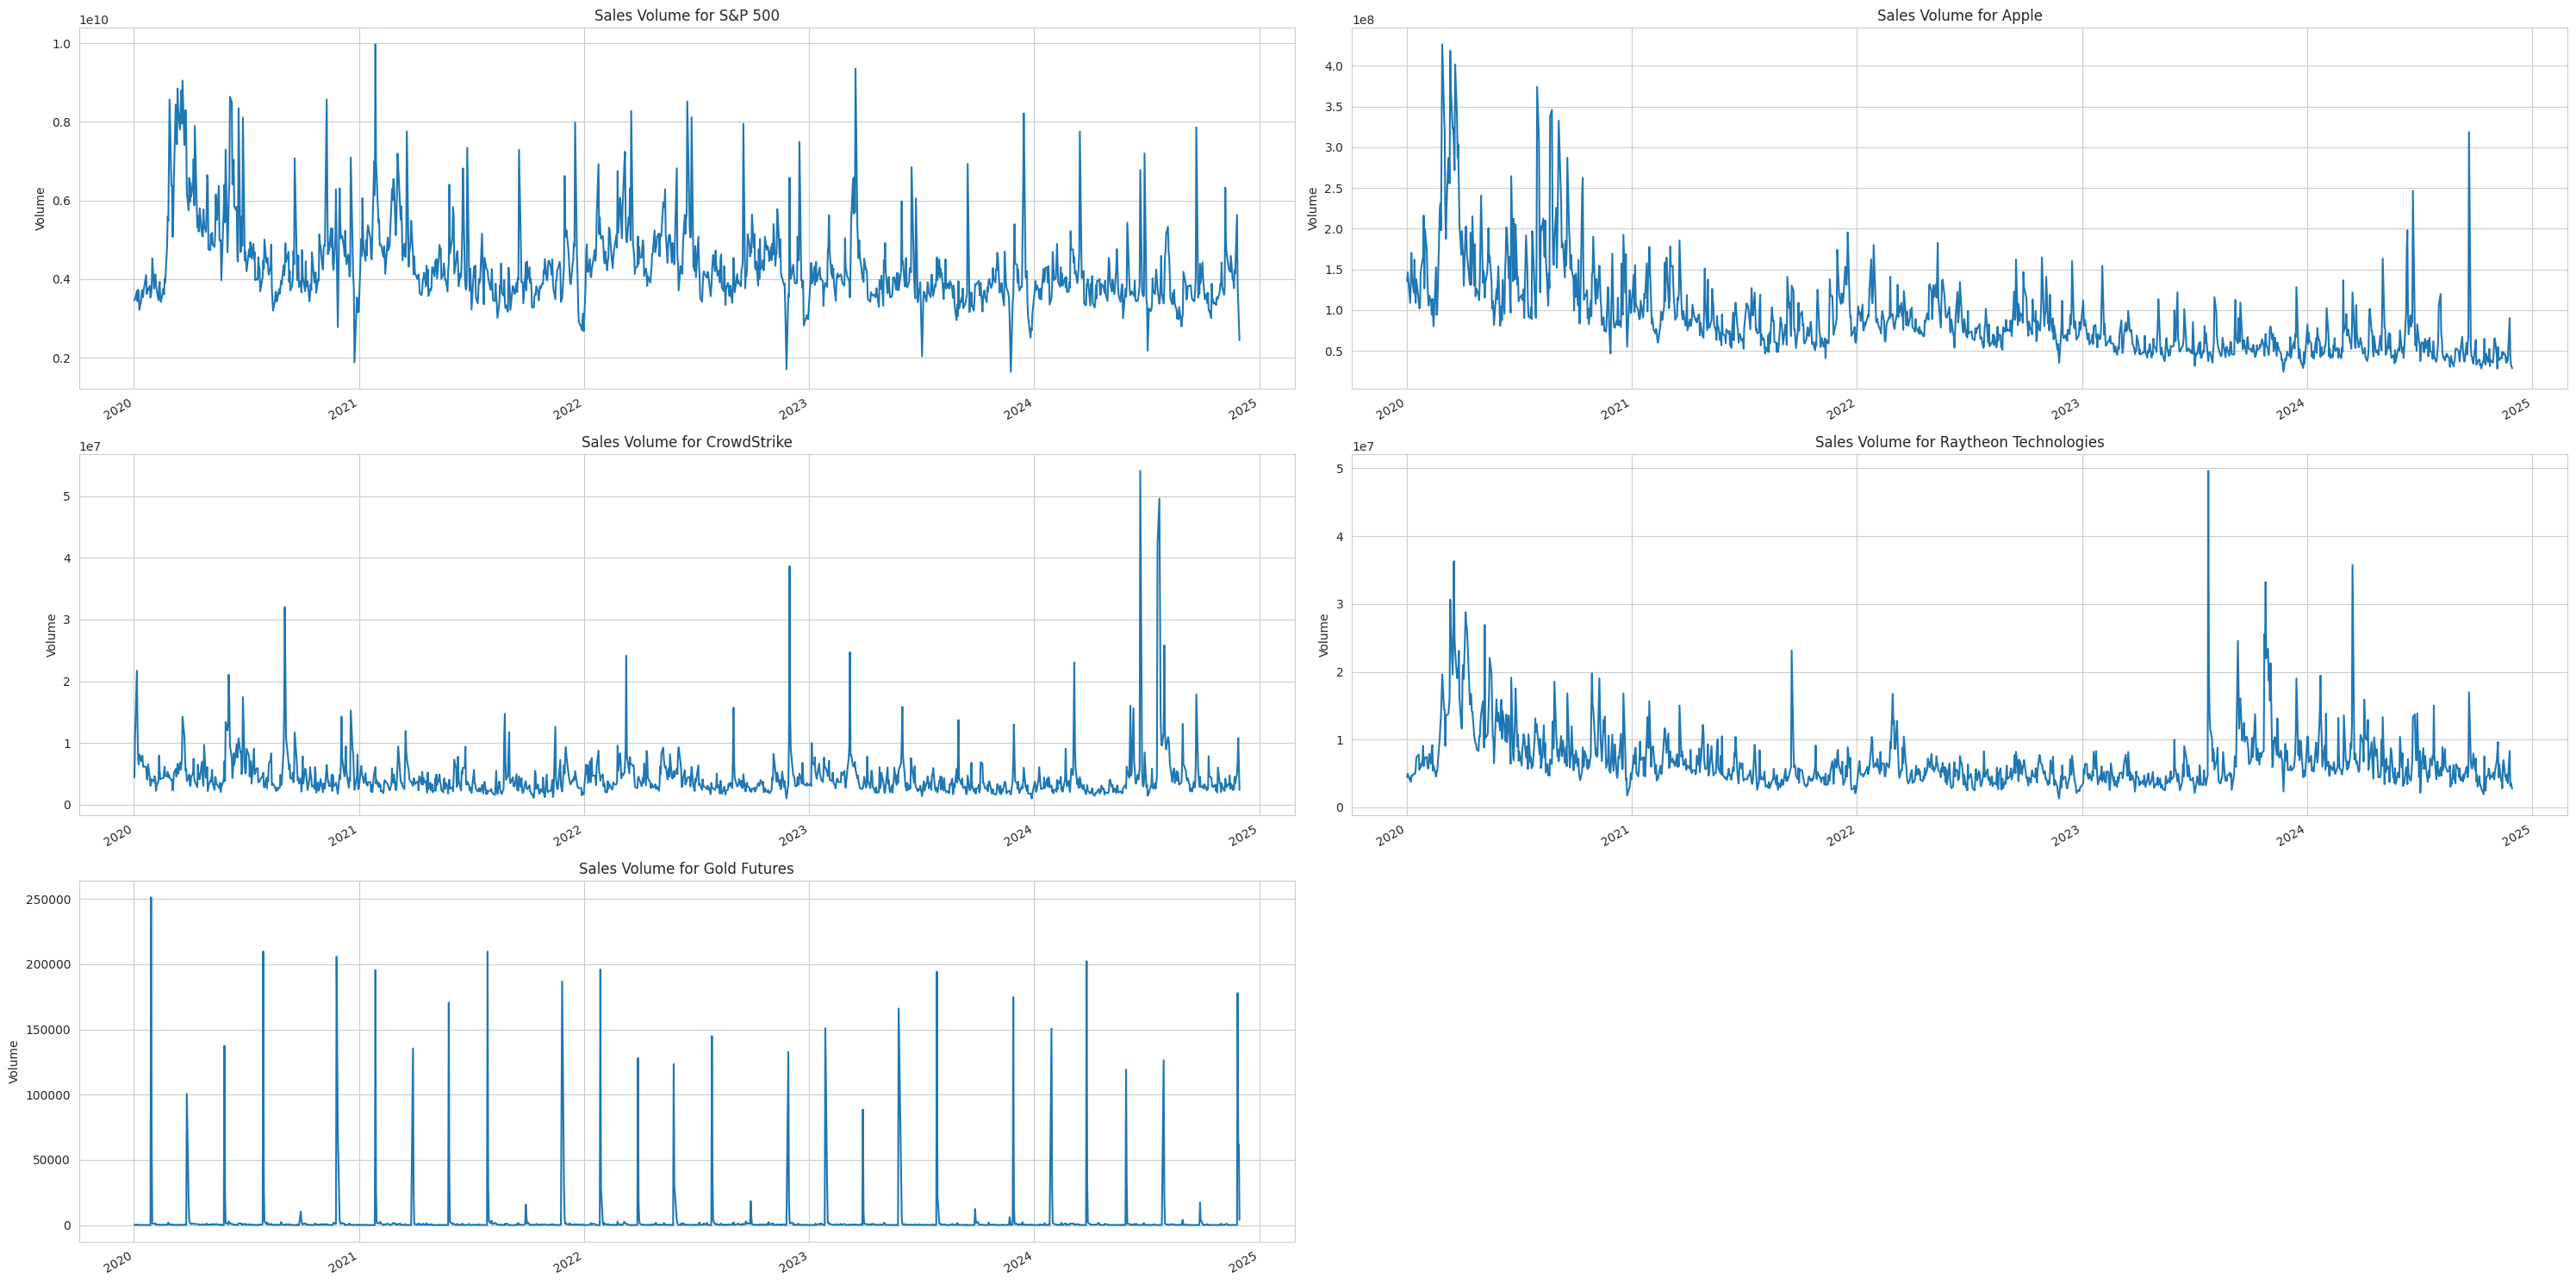

In [ ]:
plt.figure(figsize=(30, 15))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(raw_data, 1):
    plt.subplot(3, 2, i)
    stock['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {stock_names[i - 1]}")

plt.tight_layout()

## Calculating the Moving Averages

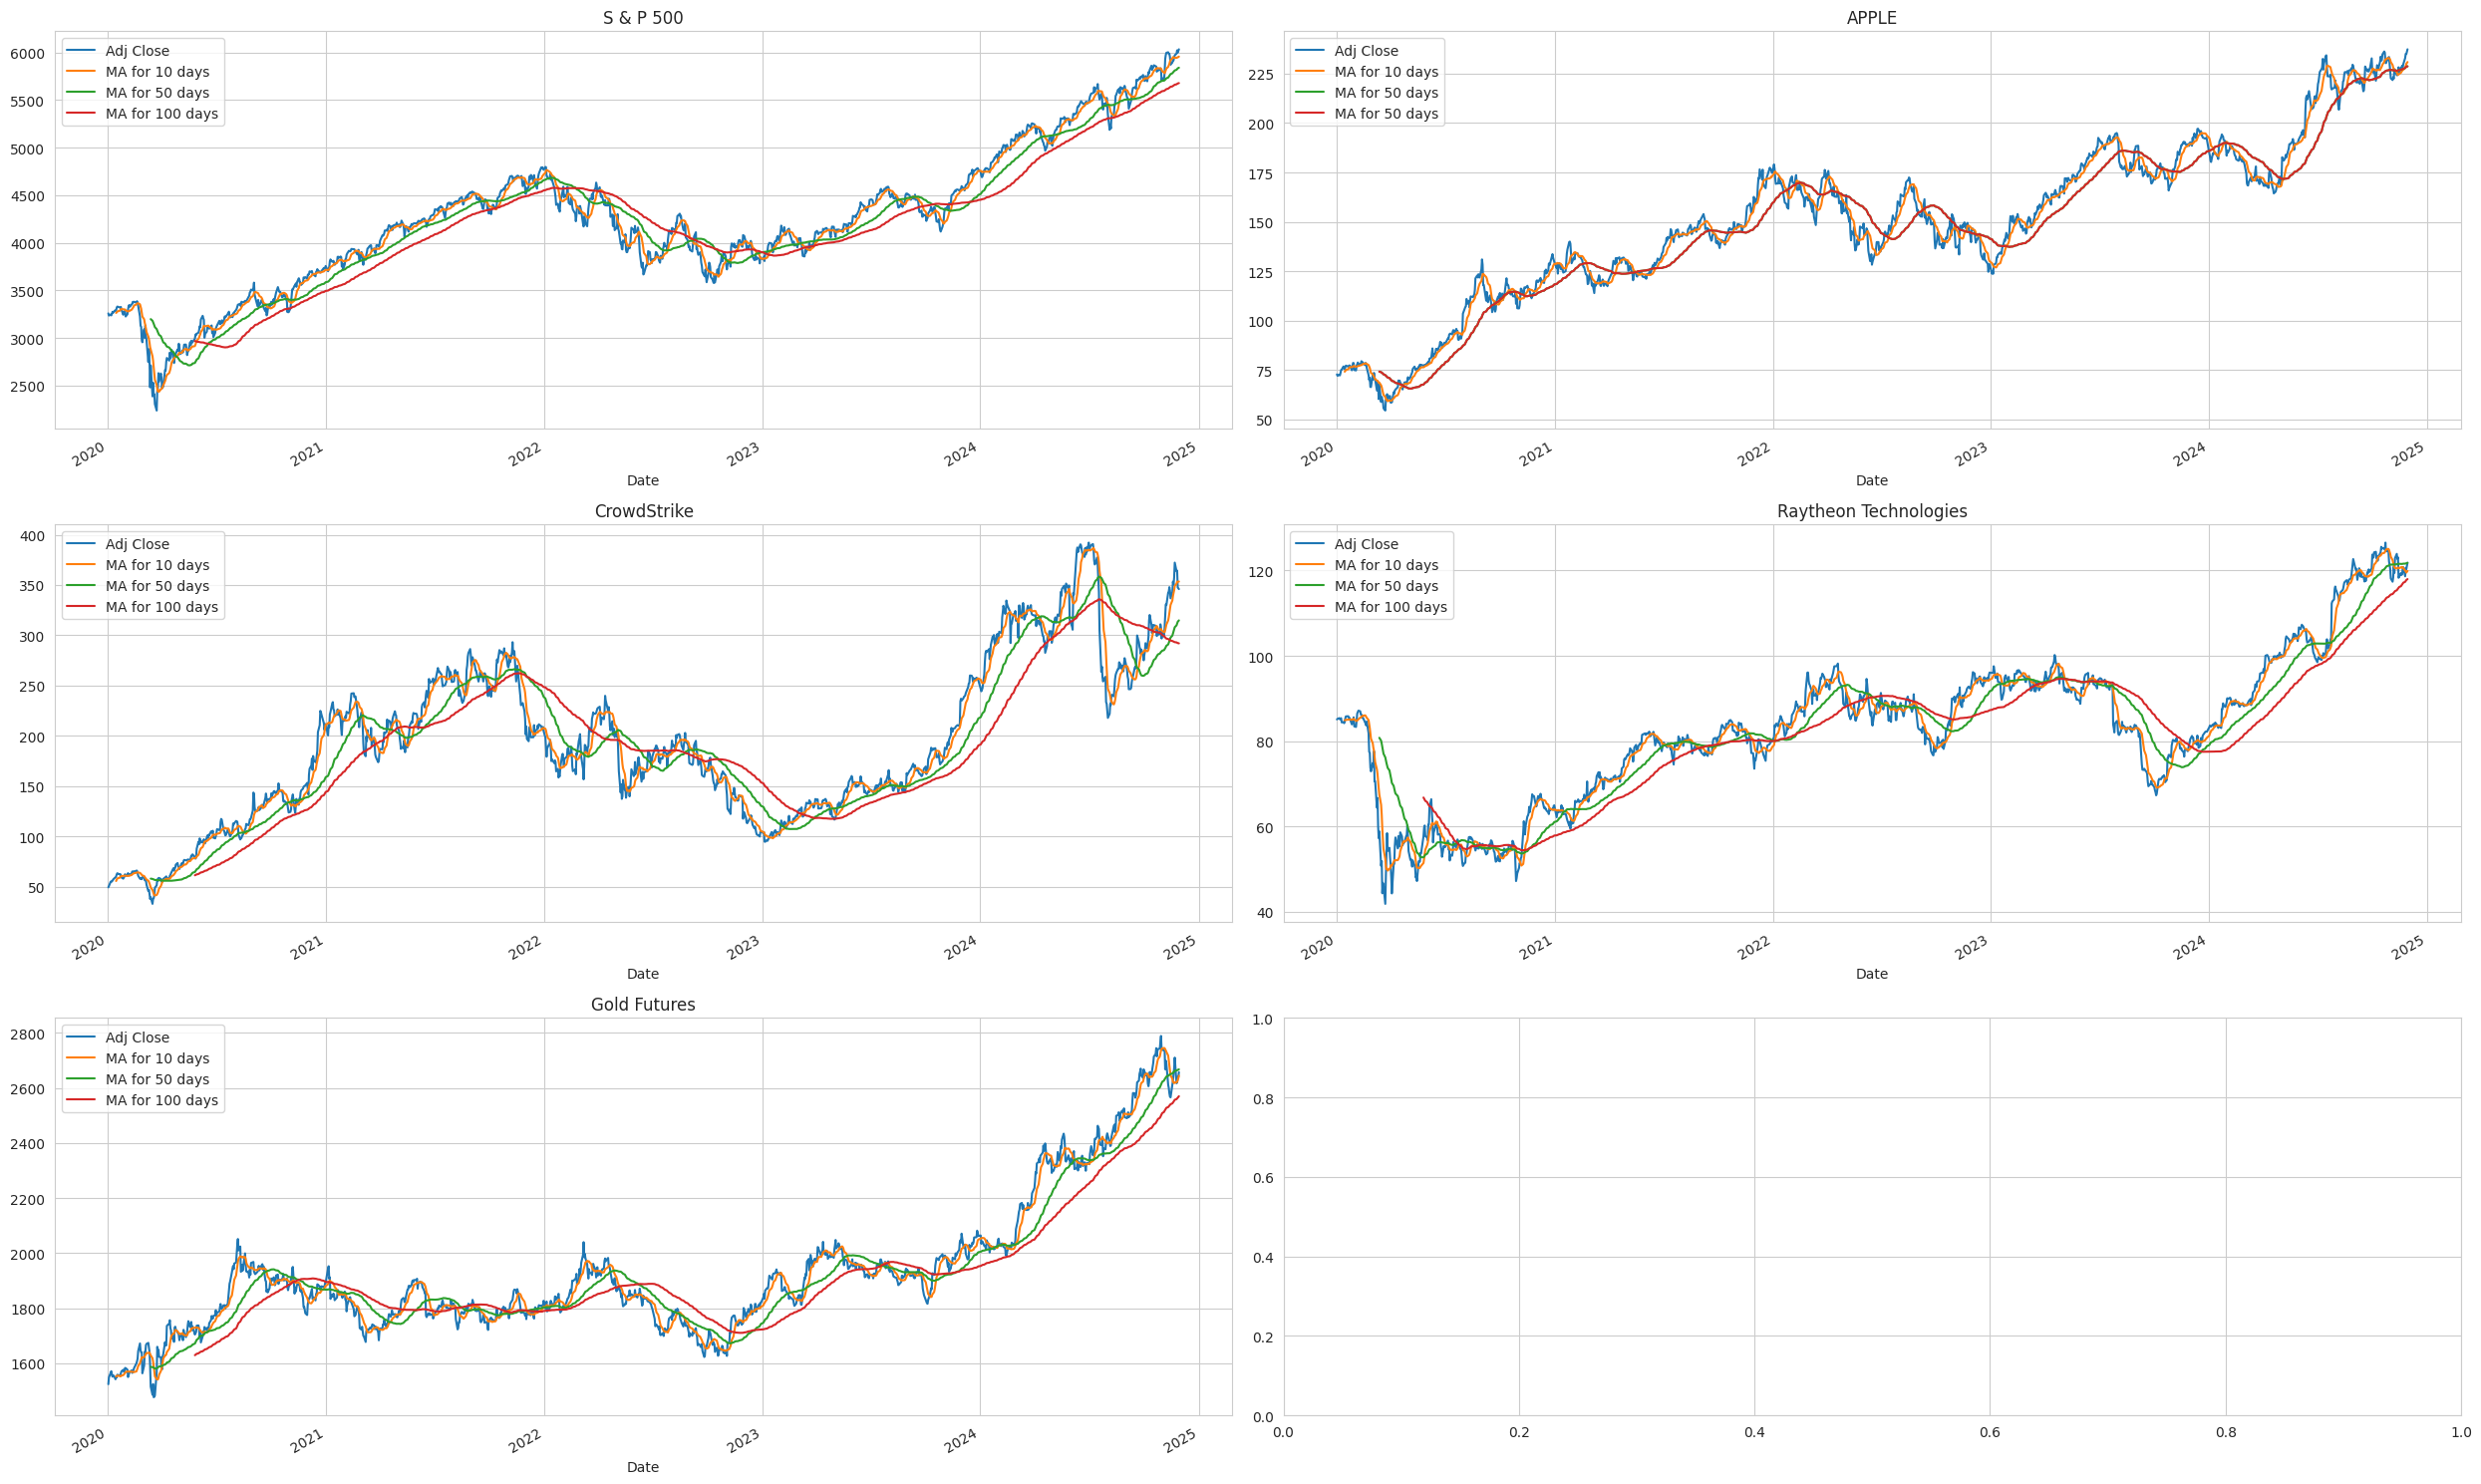

In [ ]:
ma_day = [10, 50, 100]


for ma in ma_day:
    for stock in raw_data:
        column_name = f"MA for {ma} days"
        stock[column_name] = stock['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
GSPC[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[0,0])
axes[0,0].set_title('S & P 500')

AAPL[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('APPLE')

CRWD[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,0])
axes[1,0].set_title('CrowdStrike')

RTX[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Raytheon Technologies')

GCF[['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days']].plot(ax=axes[2,0])
axes[2,0].set_title('Gold Futures')

fig.tight_layout()

## Calculating the Daily Return for Each Stock

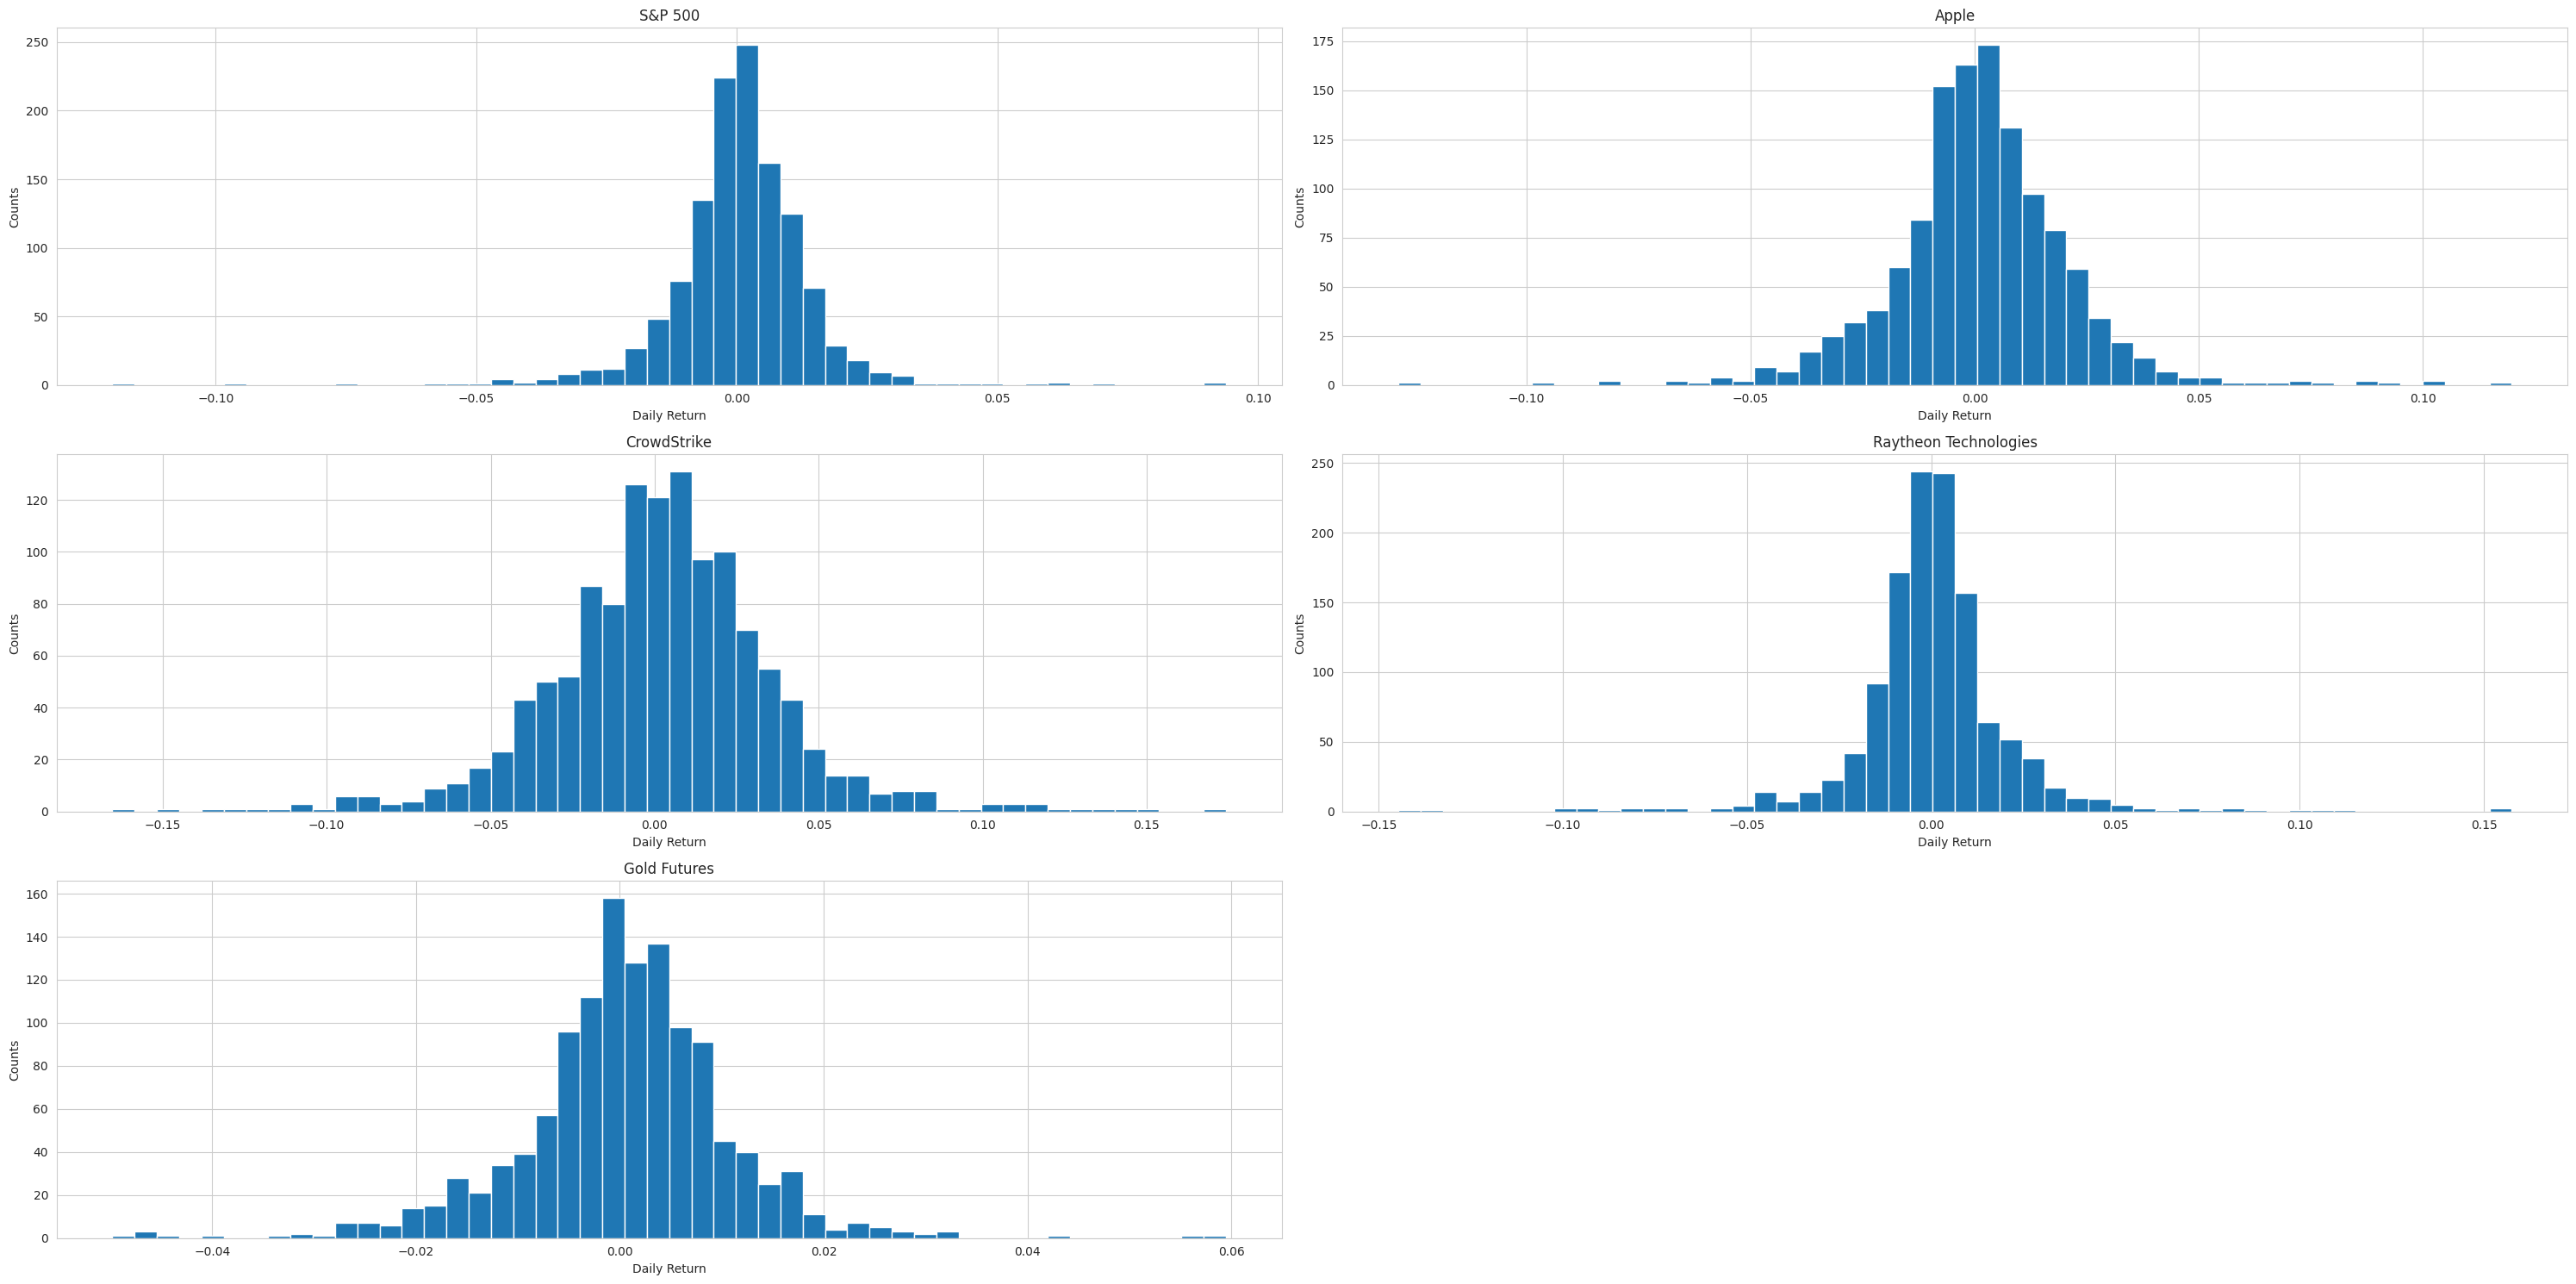

In [ ]:
for stock in raw_data:
    stock['Daily Return'] = stock['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
plt.figure(figsize=(30, 15))

for i, company in enumerate(raw_data, 1):
    plt.subplot(3, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{stock_names[i - 1]}')

plt.tight_layout()

## Training Model to Predict Open Price Apple Stock

## Splitting data sets into training and testing

In [ ]:
df = AAPL
df

,Open,High,Low,Close,Adj Close,Volume,stock_name
Date,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796036,135480400,Apple
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088287,146322800,Apple
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662704,118387200,Apple
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320984,108872000,Apple
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484344,132079200,Apple
...,...,...,...,...,...,...,...
2024-11-22,228.059998,230.720001,228.059998,229.869995,229.869995,38168300,Apple
2024-11-25,231.460007,233.250000,229.740005,232.869995,232.869995,90152800,Apple
2024-11-26,233.330002,235.570007,233.330002,235.059998,235.059998,45986200,Apple


## Prediction using a week before

In [ ]:
X = []
Y = []
first_prices = []
window_size = 5
for i in range (1, len(df) - window_size - 5, 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(5, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1226
1226
980
246


## CNN Model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


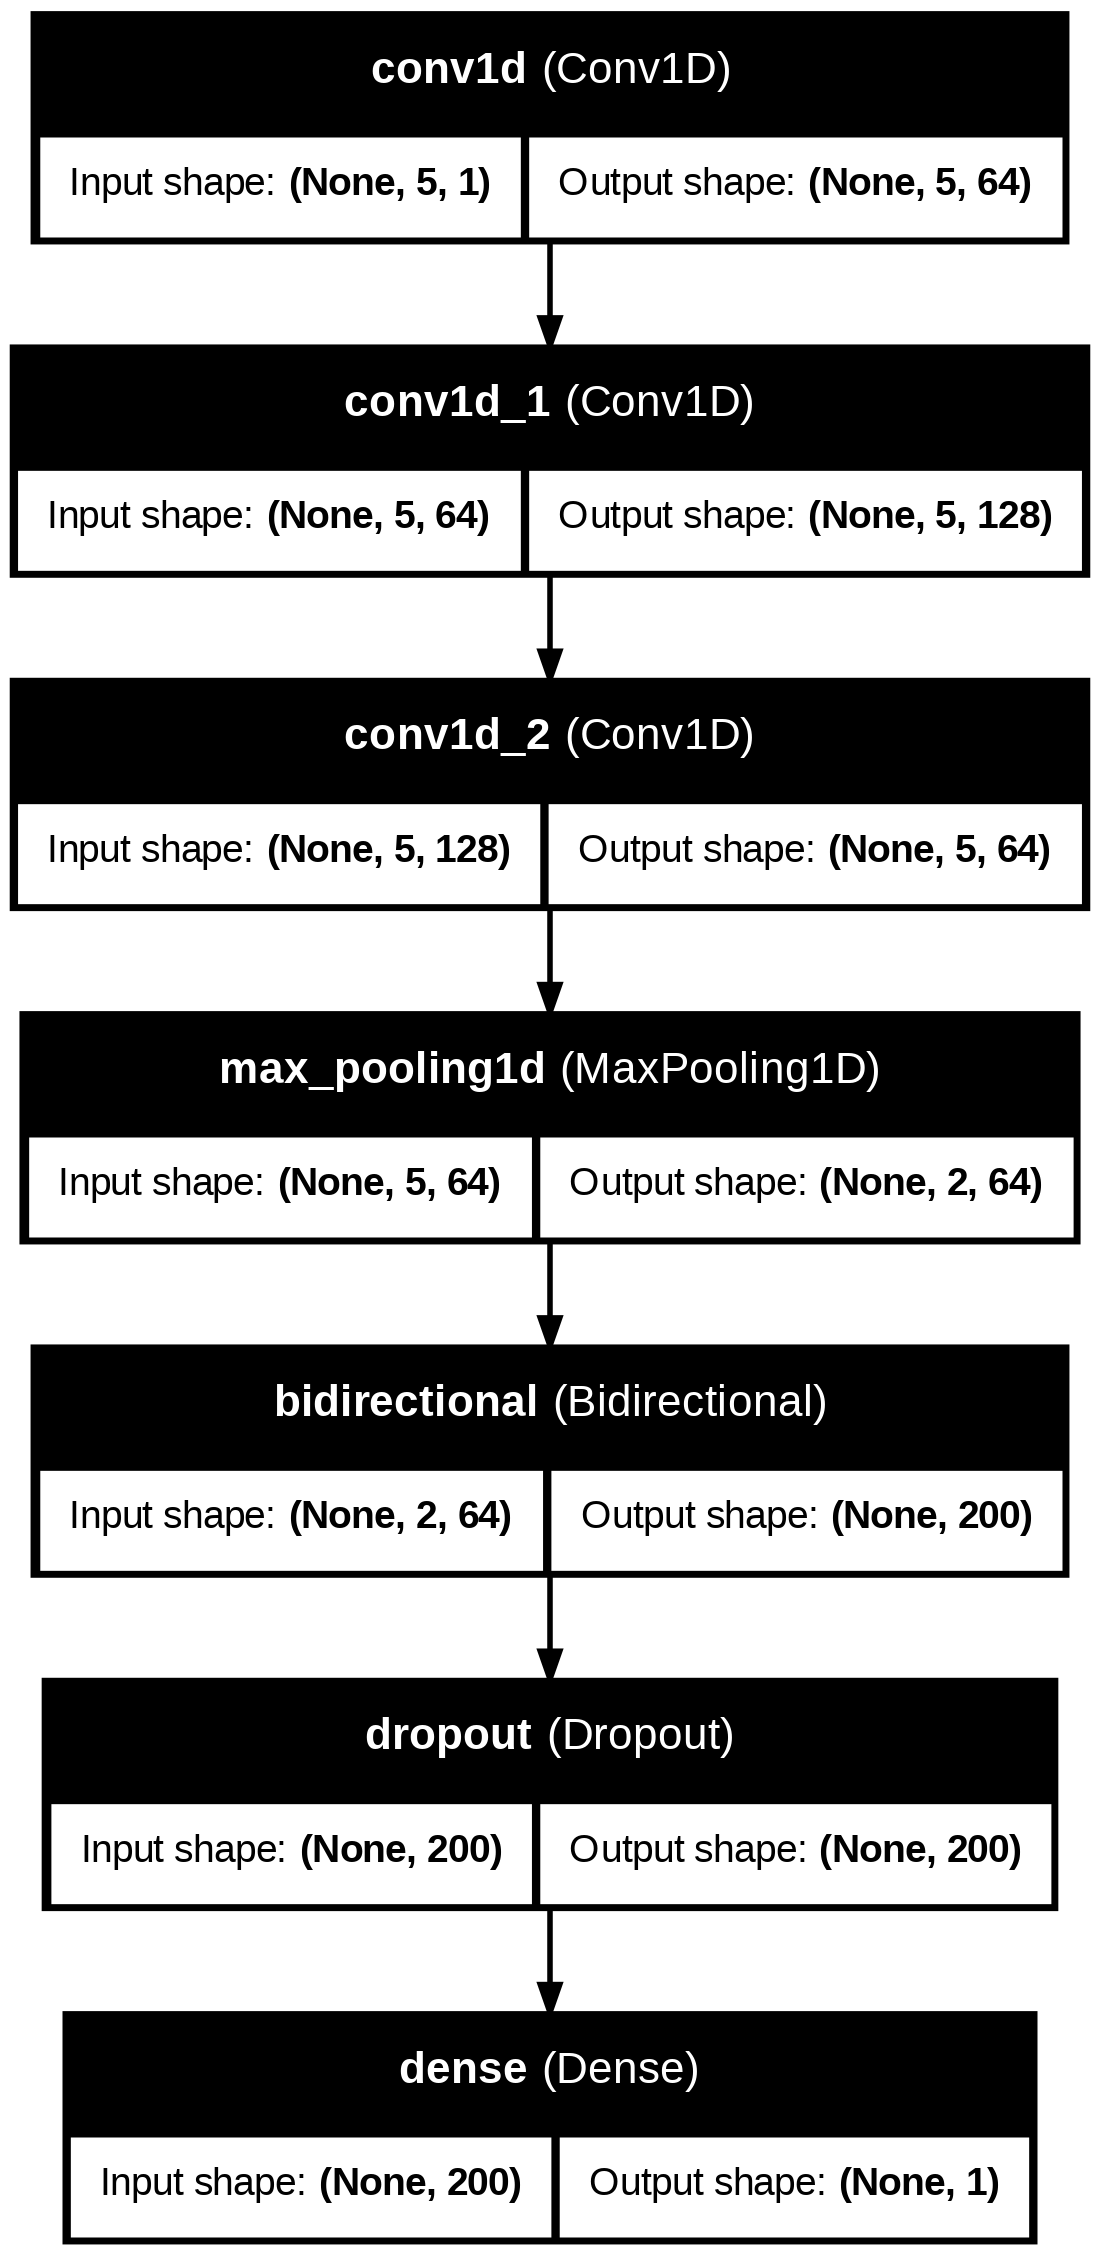

In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (5, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# history = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))


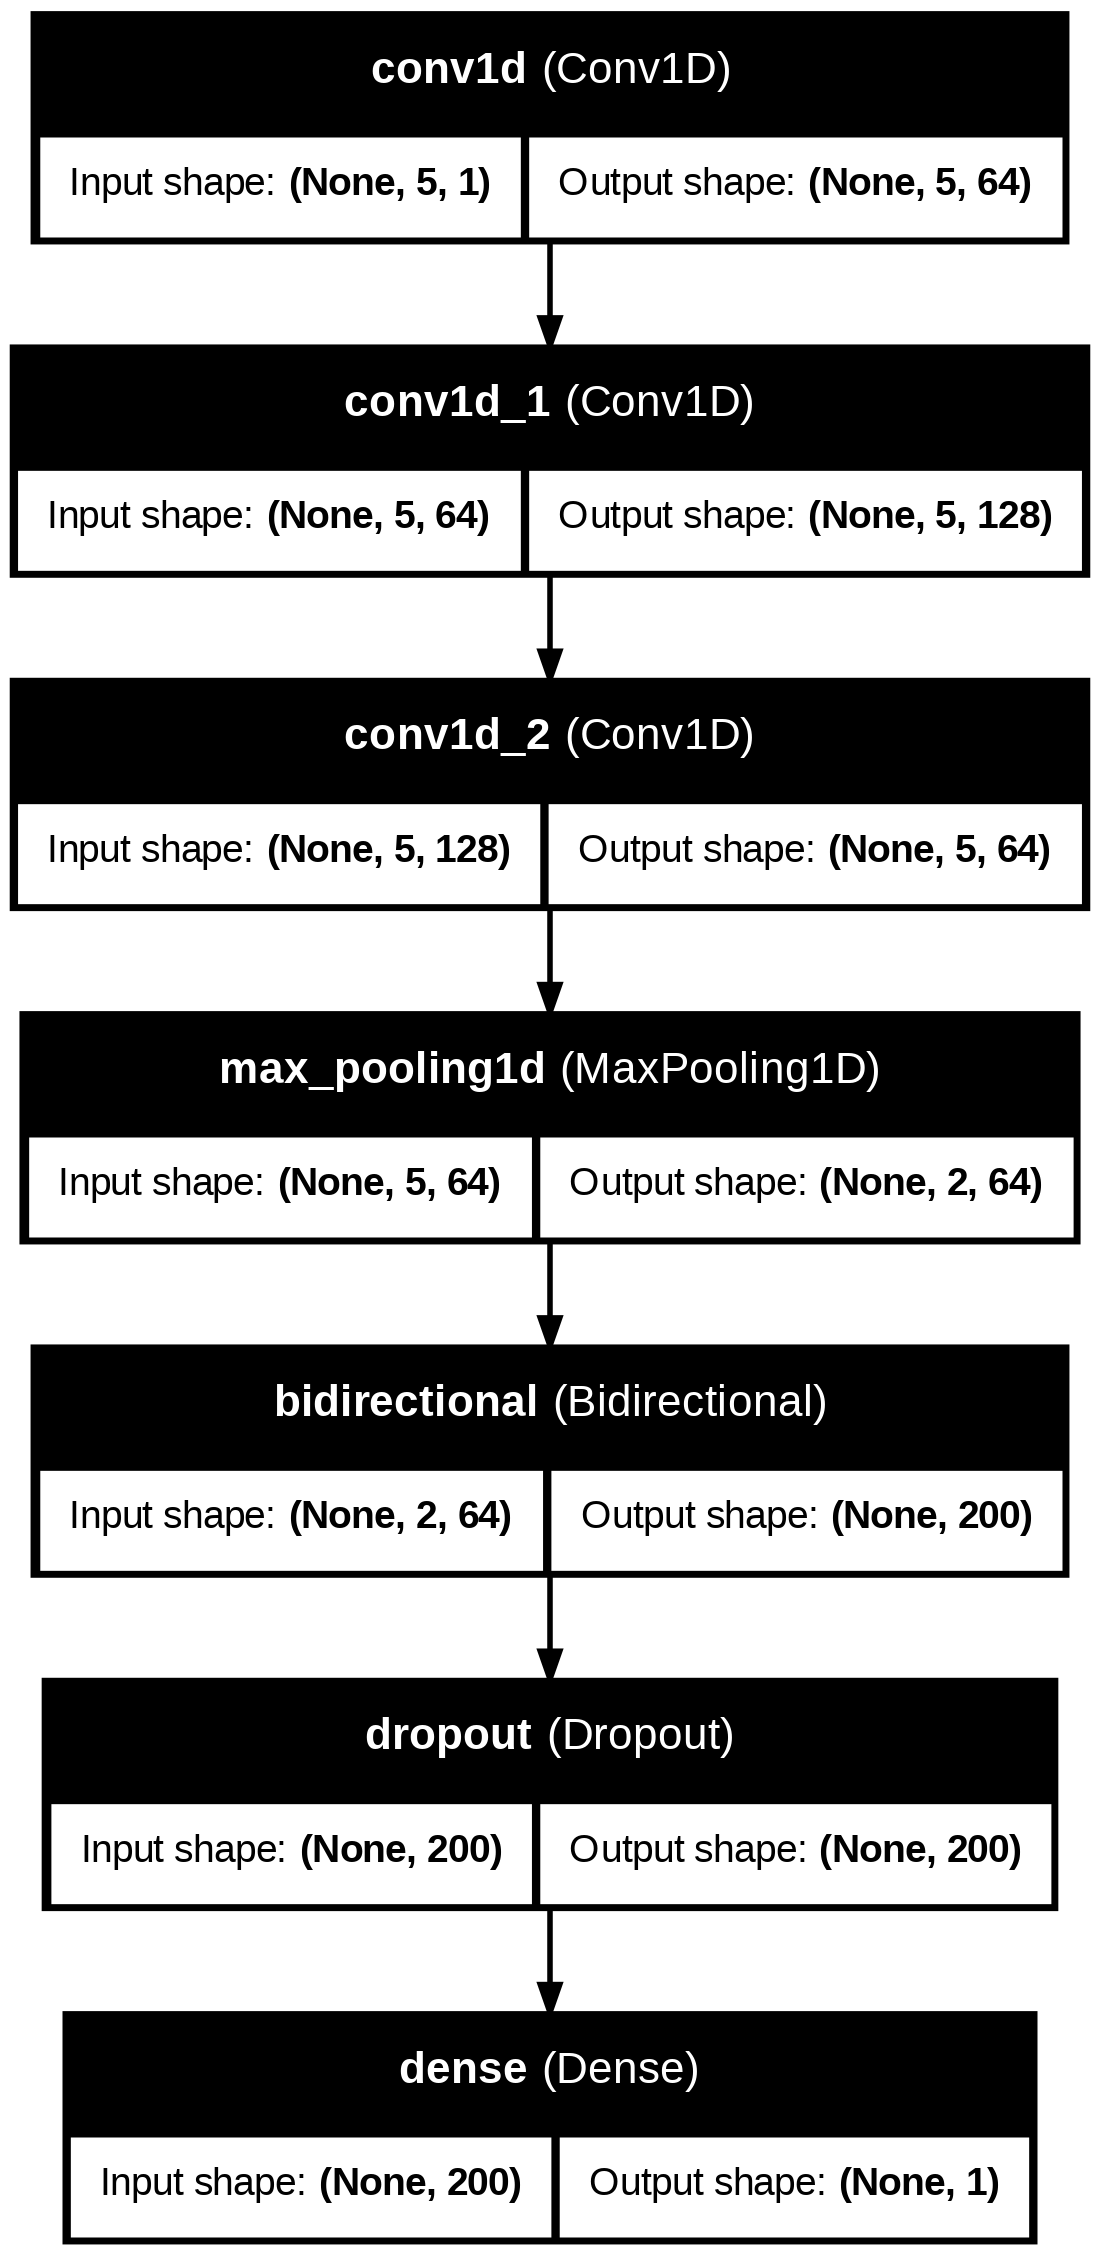

In [ ]:
from IPython.display import Image
Image('model_architecture.png')

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


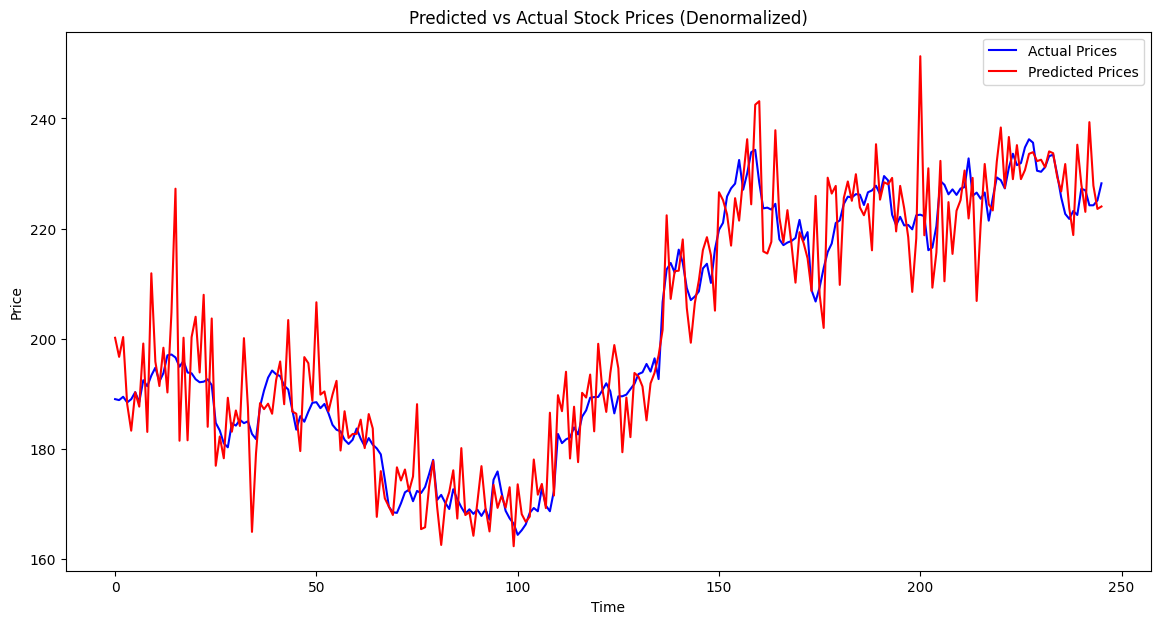

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    # Denormalize by multiplying by the first price in the corresponding window
    # print(first_prices[i + len(train_X)])
    # print(predicted_y[i])
    # print(predicted_y[i] * first_prices[i + len(train_X)])
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 7.3383


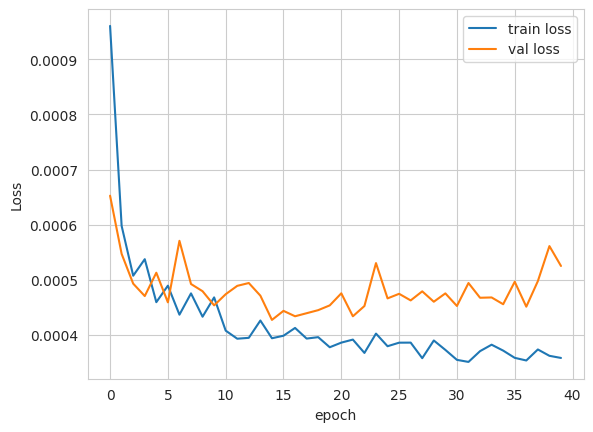

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

## Using a 100 day window

In [ ]:
from sklearn.model_selection import train_test_split

X = []
Y = []
first_prices = []
window_size = 100
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1136
1136
908
228


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
hundred_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - loss: 0.0184 - mae: 0.0886 - mse: 0.0184 - val_loss: 0.0019 - val_mae: 0.0313 - val_mse: 0.0019
Epoch 2/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0024 - mae: 0.0356 - mse: 0.0024 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 3/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0022 - mae: 0.0322 - mse: 0.0022 - val_loss: 0.0011 - val_mae: 0.0245 - val_mse: 0.0011
Epoch 4/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0017 - mae: 0.0286 - mse: 0.0017 - val_loss: 0.0014 - val_mae: 0.0261 - val_mse: 0.0014
Epoch 5/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0014 - mae: 0.0279 - mse: 0.0014 - val_loss: 8.3691e-04 - val_mae: 0.0217 - val_mse: 8.3691e-04
Epoch 6/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.0012 - mae: 0.0256 - mse: 0.0012 - val_loss: 0.0017 - val_mae: 0.0307 - val_mse: 0.0017
Epoch 7/40
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.0018 - mae: 0.0319 - mse: 0.0

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


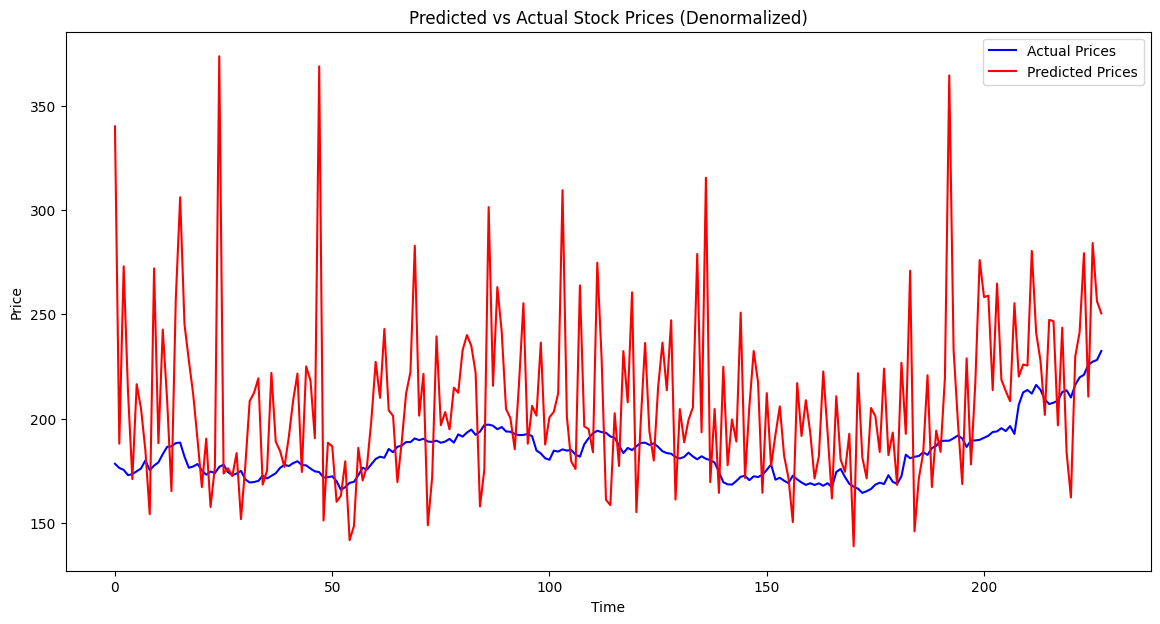

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    # Denormalize by multiplying by the first price in the corresponding window
    # print(first_prices[i + len(train_X)])
    # print(predicted_y[i])
    # print(predicted_y[i] * first_prices[i + len(train_X)])
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 45.1475


## Using 2 day prediction

In [ ]:
X = []
Y = []
first_prices = []
window_size = 2
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1234
1234
987
247


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
two_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 6.1965e-04 - mae: 0.0188 - mse: 6.1965e-04 - val_loss: 4.8367e-04 - val_mae: 0.0162 - val_mse: 4.8367e-04
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6265e-04 - mae: 0.0155 - mse: 4.6265e-04 - val_loss: 4.4374e-04 - val_mae: 0.0150 - val_mse: 4.4374e-04
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9606e-04 - mae: 0.0162 - mse: 4.9606e-04 - val_loss: 4.4062e-04 - val_mae: 0.0151 - val_mse: 4.4062e-04
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4413e-04 - mae: 0.0150 - mse: 4.4413e-04 - val_loss: 5.4781e-04 - val_mae: 0.0175 - val_mse: 5.4781e-04
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8277e-04 - mae: 0.0151 - mse: 3.8277e-04 - val_loss: 4.5639e-04 - val_mae: 0.0153 - val_mse: 4.5639e-04
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3224e-04 - mae: 0.0152 - mse: 4.3224e-04 - val_loss: 4.4258e-04 - val_mae: 0.0150 - val_mse: 4.4258e-04
Epoch 7/40

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


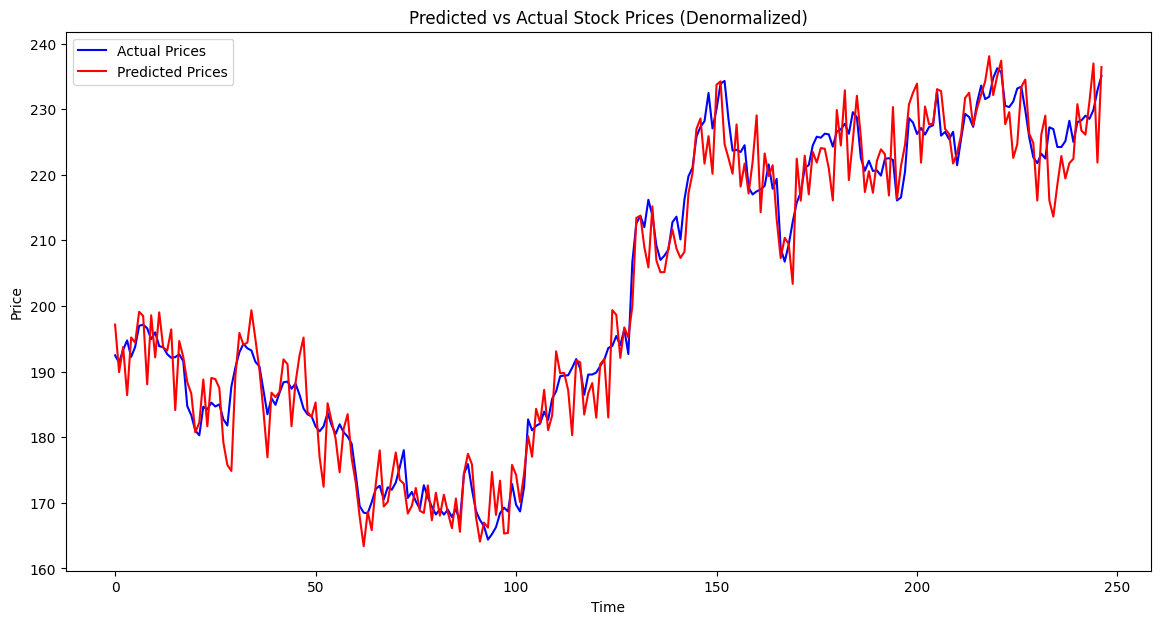

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    # Denormalize by multiplying by the first price in the corresponding window
    # print(first_prices[i + len(train_X)])
    # print(predicted_y[i])
    # print(predicted_y[i] * first_prices[i + len(train_X)])
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 4.3269


In [ ]:
joblib.dump(model, 'Apple_Stock_Model.joblib')

['Apple_Stock_Model.joblib']

In [ ]:
recent_window = df['Adj Close'][-2:].values
print("Recent 2-day closing prices:", recent_window)

Recent 2-day closing prices: [234.92999268 237.33000183]


In [ ]:
recent_df = yf.download('AAPL', start='2024-12-02', end='2024-12-07')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
actual_future_prices = recent_df['Adj Close'].tolist()

In [ ]:
num_future_days = len(actual_future_prices)
predictions = []
latest_window = df['Adj Close'].iloc[-2:].values

current_window = latest_window.copy()

for i in range(num_future_days):
    # Normalize the current window using the first price
    first_price = current_window[0]
    normalized_window = [(price - first_price) / first_price for price in current_window]
    normalized_window = np.array(normalized_window).reshape(1, 2, 1)

    # Predict the next day
    next_price_normalized = model.predict(normalized_window)
    next_price = next_price_normalized[0][0] * first_price + first_price

    # Store the prediction
    predictions.append(next_price)

    # Instead of appending the predicted price, append the actual price for comparison
    current_window = np.append(current_window[1:], actual_future_prices[i])

first_price = current_window[0]
normalized_window = [(price - first_price) / first_price for price in current_window]
normalized_window = np.array(normalized_window).reshape(1, 2, 1)

# Predict the additional day
extra_day_normalized = model.predict(normalized_window)
extra_day_price = extra_day_normalized[0][0] * first_price + first_price

# Add the extra prediction to the list
predictions.append(extra_day_price)

# Display the predicted and actual prices
print("Predicted vs Actual Prices:")
for i, (pred, actual) in enumerate(zip(predictions, actual_future_prices)):
    print(f"Day {i+1}: Predicted: {pred:.2f}, Actual: {actual:.2f}")

print(f"Day {num_future_days + 1}: Predicted: {predictions[-1]:.2f} (no actual data)")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted vs Actual Prices:
Day 1: Predicted: 237.91, Actual: 239.59
Day 2: Predicted: 240.18, Actual: 242.65
Day 3: Predicted: 243.23, Actual: 243.01
Day 4: Predicted: 243.63, Actual: 243.04
Day 5: Predicted: 243.68, Actual: 242.84
Day 6: Predicted: 243.49 (no actual data)


In [ ]:
print("Actual prices", recent_df['Adj Close'])

Actual prices Date
2024-12-02    239.589996
2024-12-03    242.649994
2024-12-04    243.009995
2024-12-05    243.039993
2024-12-06    242.839996
Name: Adj Close, dtype: float64


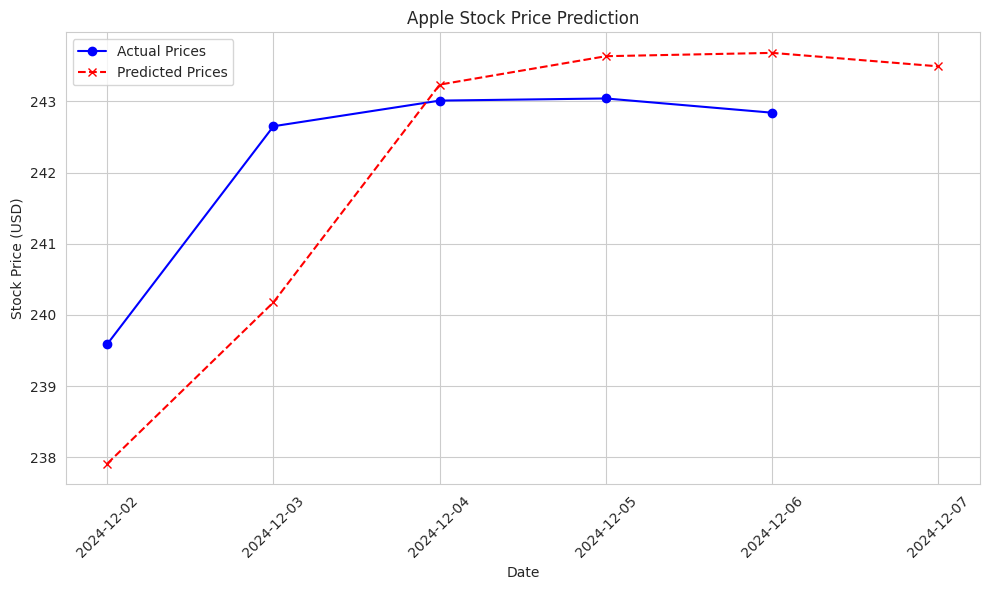

In [ ]:
days = recent_df.index.tolist()
days.append(days[-1] + pd.Timedelta(days=1))
plt.figure(figsize=(10, 6))

plt.plot(days[:-1], actual_future_prices, marker='o', label='Actual Prices', linestyle='-', color='blue')
plt.plot(days, predictions, marker='x', label='Predicted Prices', linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock Price Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Gold Futures Model


In [ ]:
df = GCF

In [ ]:
X = []
Y = []
first_prices = []
window_size = 2
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1235
1235
988
247


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
two_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.1087e-04 - mae: 0.0110 - mse: 2.1087e-04 - val_loss: 2.2856e-04 - val_mae: 0.0107 - val_mse: 2.2856e-04
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8001e-04 - mae: 0.0100 - mse: 1.8001e-04 - val_loss: 1.5059e-04 - val_mae: 0.0084 - val_mse: 1.5059e-04
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2794e-04 - mae: 0.0083 - mse: 1.2794e-04 - val_loss: 1.4231e-04 - val_mae: 0.0080 - val_mse: 1.4231e-04
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1276e-04 - mae: 0.0077 - mse: 1.1276e-04 - val_loss: 1.3747e-04 - val_mae: 0.0079 - val_mse: 1.3747e-04
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1265e-04 - mae: 0.0077 - mse: 1.1265e-04 - val_loss: 1.3487e-04 - val_mae: 0.0077 - val_mse: 1.3487e-04
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.1372e-04 - mae: 0.0080 - mse: 1.1372e-04 - val_loss: 1.3022e-04 - val_mae: 0.0075 - val_mse: 1.3022e-04
Epoch 7/40

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


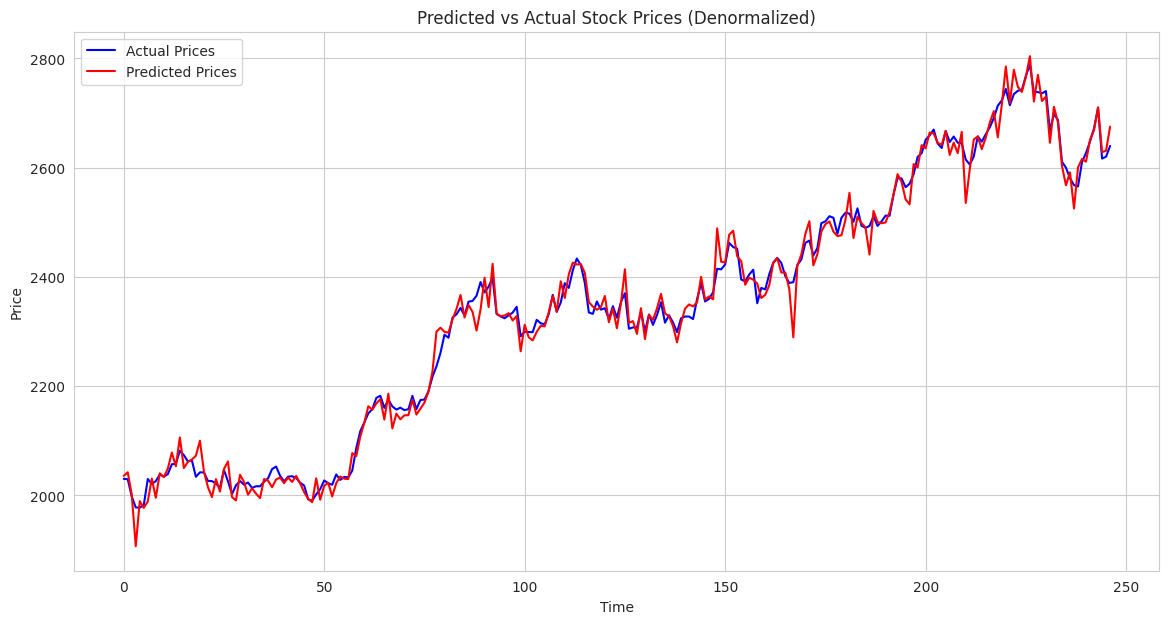

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
joblib.dump(model, 'GCF_Stock_Model.joblib')

['GCF_Stock_Model.joblib']

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 21.8317


## Build S&P 500 Model

In [ ]:
df = GSPC

In [ ]:
X = []
Y = []
first_prices = []
window_size = 2
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1234
1234
987
247


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
two_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 3.6071e-04 - mae: 0.0131 - mse: 3.6071e-04 - val_loss: 2.9115e-04 - val_mae: 0.0140 - val_mse: 2.9115e-04
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.1592e-04 - mae: 0.0124 - mse: 3.1592e-04 - val_loss: 2.2145e-04 - val_mae: 0.0111 - val_mse: 2.2145e-04
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.7604e-04 - mae: 0.0096 - mse: 1.7604e-04 - val_loss: 1.6433e-04 - val_mae: 0.0089 - val_mse: 1.6433e-04
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.1544e-04 - mae: 0.0105 - mse: 2.1544e-04 - val_loss: 1.7822e-04 - val_mae: 0.0093 - val_mse: 1.7822e-04
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7478e-04 - mae: 0.0093 - mse: 1.7478e-04 - val_loss: 2.1854e-04 - val_mae: 0.0116 - val_mse: 2.1854e-04
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9928e-04 - mae: 0.0099 - mse: 1.9928e-04 - val_loss: 1.6805e-04 - val_mae: 0.0086 - val_mse: 1.6805e-04
Epoch 7/40

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


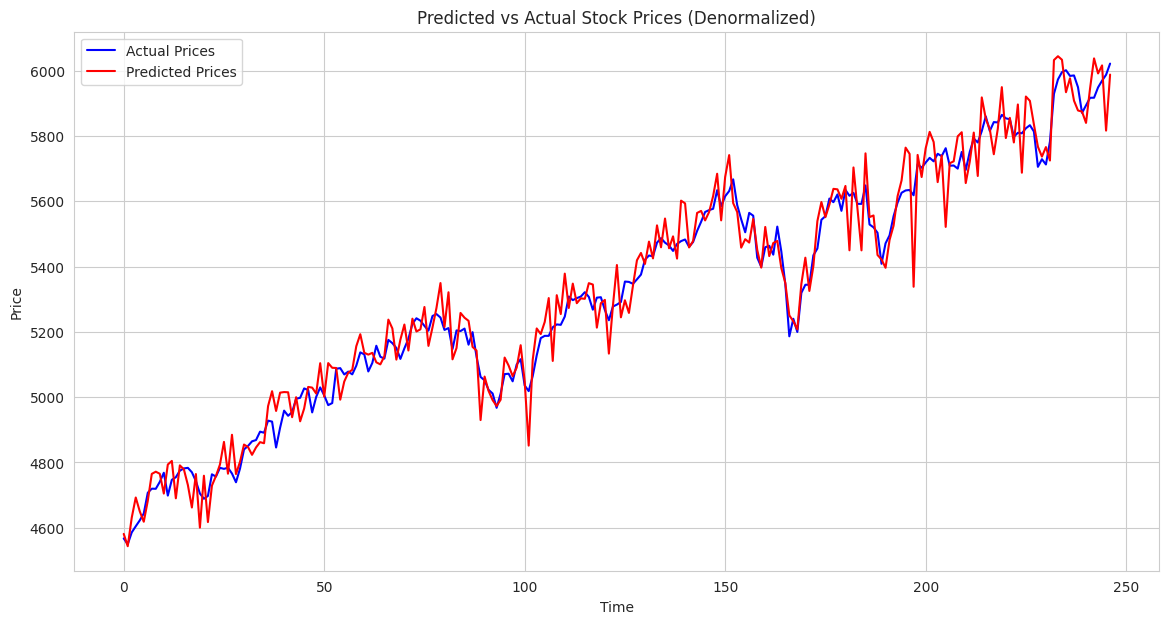

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 65.3839


In [ ]:
joblib.dump(model, 'GSPC_Stock_Model.joblib')

['GSPC_Stock_Model.joblib']

## Building Raytheon Technologies Model

In [ ]:
df = RTX

In [ ]:
X = []
Y = []
first_prices = []
window_size = 2
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1234
1234
987
247


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
two_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 8.4361e-04 - mae: 0.0178 - mse: 8.4361e-04 - val_loss: 7.1940e-04 - val_mae: 0.0179 - val_mse: 7.1940e-04
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.6508e-04 - mae: 0.0143 - mse: 4.6508e-04 - val_loss: 6.9894e-04 - val_mae: 0.0177 - val_mse: 6.9894e-04
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6438e-04 - mae: 0.0145 - mse: 4.6438e-04 - val_loss: 5.8226e-04 - val_mae: 0.0148 - val_mse: 5.8226e-04
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2012e-04 - mae: 0.0134 - mse: 4.2012e-04 - val_loss: 6.0014e-04 - val_mae: 0.0153 - val_mse: 6.0014e-04
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9994e-04 - mae: 0.0136 - mse: 3.9994e-04 - val_loss: 5.5975e-04 - val_mae: 0.0151 - val_mse: 5.5975e-04
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.1054e-04 - mae: 0.0142 - mse: 5.1054e-04 - val_loss: 5.4997e-04 - val_mae: 0.0145 - val_mse: 5.4997e-04
Epoch 7/40

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


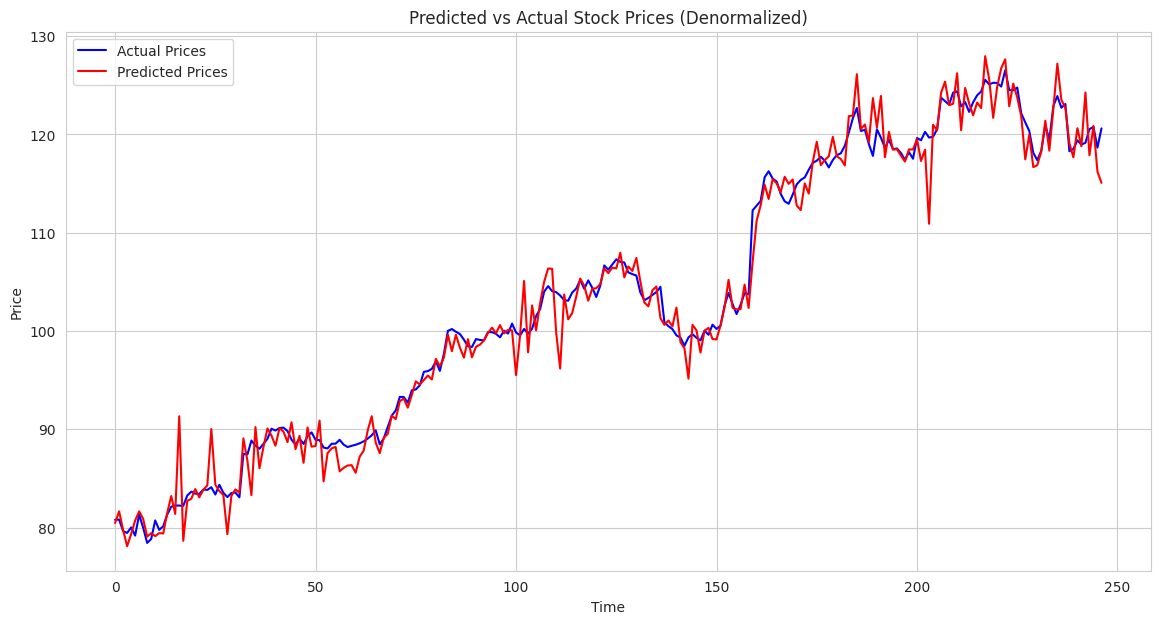

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 1.9093


In [ ]:
joblib.dump(model, 'RTX_Stock_Model.joblib')

['RTX_Stock_Model.joblib']

## Build CrowdStrike Model

In [ ]:
df = CRWD

In [ ]:
X = []
Y = []
first_prices = []
window_size = 2
for i in range (1, len(df) - window_size , 1):
  first = df.iloc[i, 4]
  first_prices.append(first)
  temp = []
  temp2 = []
  for j in range(window_size):
    temp.append((df.iloc[i + j, 4] - first) / first)
  temp2.append((df.iloc[i + window_size, 4] - first) / first)
  X.append(np.array(temp).reshape(window_size, 1))
  Y.append(np.array(temp2).reshape(1,1))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(len(X))
print(len(Y))

train_X = np.array(X_train).reshape(len(X_train), window_size, 1)
test_X = np.array(X_test).reshape(len(X_test), window_size, 1)

train_y = np.array(y_train).reshape(len(y_train))
test_y = np.array(y_test).reshape(len(y_test))



print(len(train_X))
print(len(test_X))

1234
1234
987
247


In [ ]:
model = tf.keras.Sequential()

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape= (window_size, 1)))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Bidirectional(GRU(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
two_day_model = model.fit(train_X, train_y, epochs=40, verbose=1, shuffle=True, validation_data=(test_X, test_y))

Epoch 1/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0025 - mae: 0.0352 - mse: 0.0025 - val_loss: 0.0015 - val_mae: 0.0295 - val_mse: 0.0015
Epoch 2/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - mae: 0.0280 - mse: 0.0014 - val_loss: 0.0018 - val_mae: 0.0332 - val_mse: 0.0018
Epoch 3/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - mae: 0.0282 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0265 - val_mse: 0.0012
Epoch 4/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - mae: 0.0278 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0261 - val_mse: 0.0012
Epoch 5/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014 - mae: 0.0263 - mse: 0.0014 - val_loss: 0.0012 - val_mae: 0.0260 - val_mse: 0.0012
Epoch 6/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - mae: 0.0247 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0266 - val_mse: 0.0012
Epoch 7/40
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - mae: 0.0260 - mse: 0.0012 - val_loss: 

In [ ]:
predicted_y = model.predict(test_X)
predicted_y = predicted_y.reshape(-1)
test_y = test_y.reshape(-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


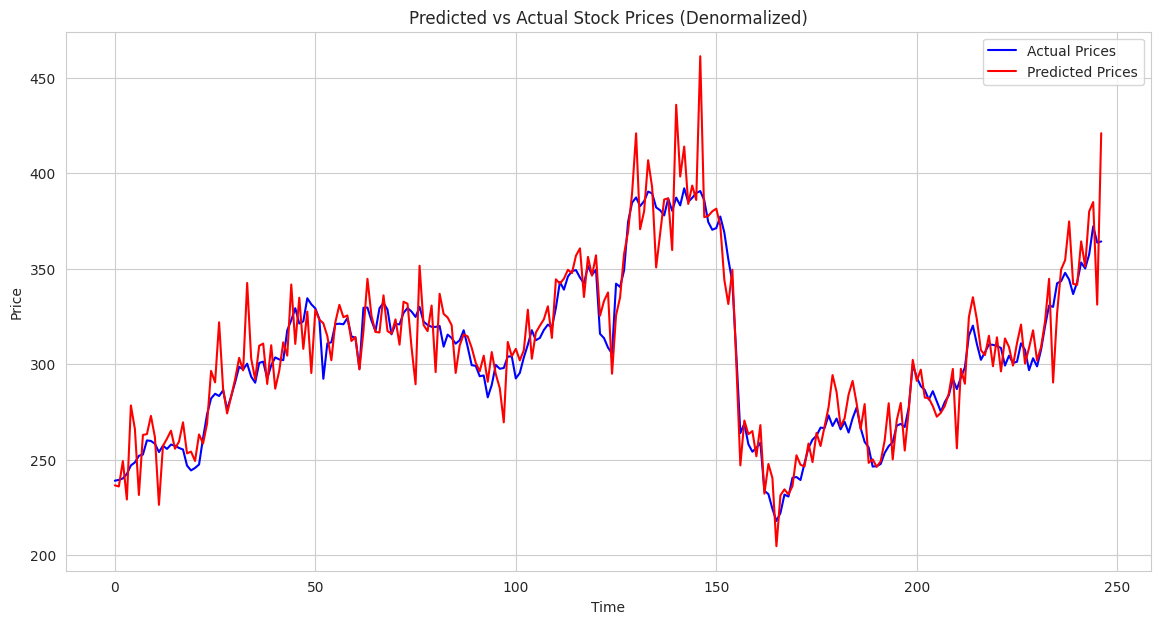

In [ ]:
denormalized_predictions = []
denormalized_actuals = []

for i in range(len(predicted_y)):
    denormalized_predictions.append((predicted_y[i] * first_prices[i + len(train_X)]) + first_prices[i + len(train_X)])
    denormalized_actuals.append(first_prices[i + len(train_X)])

plt.figure(figsize=(14, 7))

# Plot actual (denormalized) prices
plt.plot(denormalized_actuals, label="Actual Prices", color='blue')

# Plot predicted (denormalized) prices
plt.plot(denormalized_predictions, label="Predicted Prices", color='red')

plt.title("Predicted vs Actual Stock Prices (Denormalized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(denormalized_actuals,denormalized_predictions ))

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

Root Mean Square Error (RMSE): 14.2790


In [ ]:
joblib.dump(model, 'CRWD_Stock_Model.joblib')

['CRWD_Stock_Model.joblib']

In [ ]:
 from tensorflow.keras.utils import plot_model
print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 5, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 5, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ (None, 5, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 200)                 │          99,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 448,205 (1.71 MB)

 Trainable params: 149,401 (583.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 298,804 (1.14 MB)

None


In [ ]:
model.evaluate(test_X, test_y)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5737e-04 - mae: 0.0136 - mse: 3.5737e-04  


[0.00038835659506730735, 0.00038835659506730735, 0.014260700903832912]